In [1]:
!pip install imageio[ffmpeg] pillow --quiet

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import imageio
from PIL import Image
import io
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ═══════════════════════════════════════════════════════════════
#  MATRICES DE TRANSFORMACIÓN HOMOGÉNEAS (3x3 para 2D)
# ═══════════════════════════════════════════════════════════════

def mat_traslacion(tx, ty):
    """Matriz de traslación 2D homogénea."""
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0,  1]
    ], dtype=float)

def mat_rotacion(angulo_rad):
    """Matriz de rotación 2D homogénea (antihorario)."""
    c, s = np.cos(angulo_rad), np.sin(angulo_rad)
    return np.array([
        [c, -s, 0],
        [s,  c, 0],
        [0,  0, 1]
    ], dtype=float)

def mat_escala(sx, sy):
    """Matriz de escala 2D homogénea."""
    return np.array([
        [sx,  0, 0],
        [ 0, sy, 0],
        [ 0,  0, 1]
    ], dtype=float)

def mat_reflejo_x():
    """Reflexión sobre el eje X."""
    return np.array([[1,0,0],[0,-1,0],[0,0,1]], dtype=float)

def mat_cizalla(shx, shy):
    """Cizalla (shear) 2D homogénea."""
    return np.array([[1, shx, 0],[shy, 1, 0],[0, 0, 1]], dtype=float)

def aplicar_transformacion(puntos, M):
    """
    Aplica la matriz M (3x3) a un array de puntos (N, 2).
    Retorna los puntos transformados (N, 2).
    """
    # Convertir a coordenadas homogéneas (N, 3)
    N = puntos.shape[0]
    hom = np.hstack([puntos, np.ones((N, 1))])  # (N, 3)
    # Aplicar M: (3,3) @ (3,N) → (3,N)
    transformados = (M @ hom.T).T                # (N, 3)
    return transformados[:, :2]                  # (N, 2)

def formato_matriz(M, nombre='M'):
    """Representa una matriz 3x3 como string legible."""
    filas = []
    for fila in M:
        filas.append('  [' + '  '.join(f'{v:7.3f}' for v in fila) + ']')
    return f'{nombre} =\n' + '\n'.join(filas)

# ── Demo de matrices ──────────────────────────────────────────
T = mat_traslacion(2, 1)
R = mat_rotacion(np.pi / 4)   # 45°
S = mat_escala(2, 0.5)

print(formato_matriz(T, 'Traslación (tx=2, ty=1)'))
print()
print(formato_matriz(R, 'Rotación (45°)'))
print()
print(formato_matriz(S, 'Escala (sx=2, sy=0.5)'))
print()
# Composición: primero escala, luego rota, luego traslada
M_compuesta = T @ R @ S
print(formato_matriz(M_compuesta, 'Compuesta  T·R·S'))

Traslación (tx=2, ty=1) =
  [  1.000    0.000    2.000]
  [  0.000    1.000    1.000]
  [  0.000    0.000    1.000]

Rotación (45°) =
  [  0.707   -0.707    0.000]
  [  0.707    0.707    0.000]
  [  0.000    0.000    1.000]

Escala (sx=2, sy=0.5) =
  [  2.000    0.000    0.000]
  [  0.000    0.500    0.000]
  [  0.000    0.000    1.000]

Compuesta  T·R·S =
  [  1.414   -0.354    2.000]
  [  1.414    0.354    1.000]
  [  0.000    0.000    1.000]


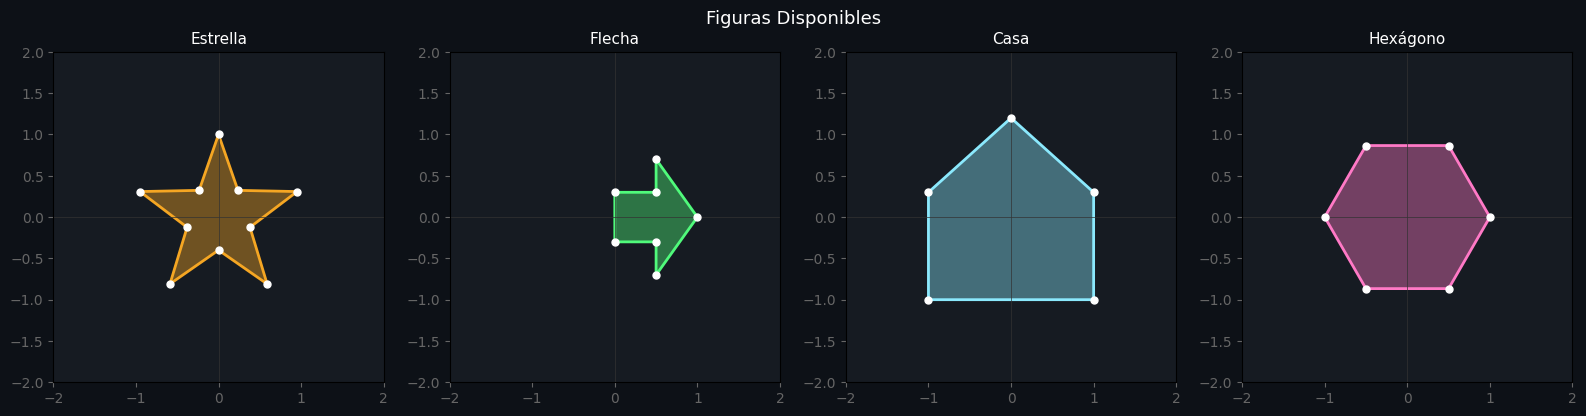

In [3]:
def figura_estrella(n_puntas=5, r_ext=1.0, r_int=0.4, centro=(0,0)):
    """Genera los vértices de una estrella de n puntas."""
    angulos = np.linspace(np.pi/2, np.pi/2 + 2*np.pi, 2*n_puntas, endpoint=False)
    radios  = np.tile([r_ext, r_int], n_puntas)
    x = centro[0] + radios * np.cos(angulos)
    y = centro[1] + radios * np.sin(angulos)
    return np.column_stack([x, y])

def figura_flecha(escala=1.0):
    """Genera los vértices de una flecha apuntando a la derecha."""
    pts = np.array([
        [0.0,  0.3], [0.5,  0.3], [0.5,  0.7],
        [1.0,  0.0], [0.5, -0.7], [0.5, -0.3],
        [0.0, -0.3]
    ]) * escala
    return pts

def figura_casa(escala=1.0):
    """Polígono con forma de casa."""
    pts = np.array([
        [-1.0, -1.0], [ 1.0, -1.0], [ 1.0,  0.3],
        [ 0.0,  1.2], [-1.0,  0.3]
    ]) * escala
    return pts

def figura_poligono(n=6, radio=1.0):
    """Polígono regular de n lados."""
    angulos = np.linspace(0, 2*np.pi, n, endpoint=False)
    return np.column_stack([radio*np.cos(angulos), radio*np.sin(angulos)])

# Figura principal: estrella de 5 puntas centrada en el origen
FIGURA_BASE = figura_estrella(n_puntas=5, r_ext=1.5, r_int=0.6)

# Visualizar
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.patch.set_facecolor('#0d1117')
figuras = [
    (figura_estrella(), 'Estrella', '#f5a623'),
    (figura_flecha(),   'Flecha',   '#50fa7b'),
    (figura_casa(),     'Casa',     '#8be9fd'),
    (figura_poligono(), 'Hexágono', '#ff79c6'),
]
for ax, (pts, nombre, color) in zip(axes, figuras):
    cerrado = np.vstack([pts, pts[0]])
    ax.fill(cerrado[:,0], cerrado[:,1], color=color, alpha=0.4)
    ax.plot(cerrado[:,0], cerrado[:,1], color=color, lw=2)
    ax.scatter(pts[:,0], pts[:,1], color='white', s=25, zorder=5)
    ax.set_aspect('equal'); ax.set_facecolor('#161b22')
    ax.set_title(nombre, color='white', fontsize=11)
    ax.tick_params(colors='#666'); ax.set_xlim(-2,2); ax.set_ylim(-2,2)
    ax.axhline(0, color='#333', lw=0.5); ax.axvline(0, color='#333', lw=0.5)
plt.suptitle('Figuras Disponibles', color='white', fontsize=13)
plt.tight_layout()
plt.savefig('figuras_base.png', dpi=120, bbox_inches='tight', facecolor='#0d1117')
plt.show()

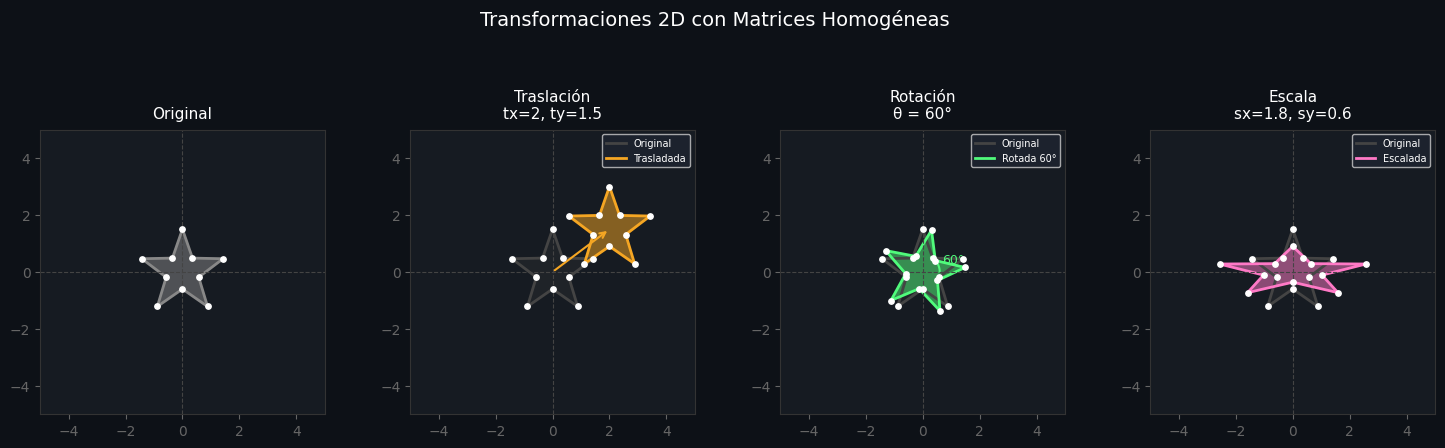

✅ Vista estática guardada


In [4]:
def dibujar_figura(ax, puntos, color, alpha=0.5, lw=2, label=''):
    cerrado = np.vstack([puntos, puntos[0]])
    ax.fill(cerrado[:,0], cerrado[:,1], color=color, alpha=alpha)
    ax.plot(cerrado[:,0], cerrado[:,1], color=color, lw=lw, label=label)
    ax.scatter(puntos[:,0], puntos[:,1], color='white', s=15, zorder=5)

def estilo_ax(ax, titulo, lim=5):
    ax.set_facecolor('#161b22')
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')
    ax.axhline(0, color='#444', lw=0.8, ls='--')
    ax.axvline(0, color='#444', lw=0.8, ls='--')
    ax.set_title(titulo, color='white', fontsize=11, pad=8)
    ax.tick_params(colors='#666')
    for spine in ax.spines.values(): spine.set_edgecolor('#333')

fig = plt.figure(figsize=(18, 5))
fig.patch.set_facecolor('#0d1117')
gs  = GridSpec(1, 4, figure=fig, wspace=0.3)

# ── Original ──────────────────────────────────────────────────
ax0 = fig.add_subplot(gs[0])
dibujar_figura(ax0, FIGURA_BASE, '#888888', label='Original')
estilo_ax(ax0, 'Original')

# ── Traslación ────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[1])
M_t = mat_traslacion(2, 1.5)
fig_t = aplicar_transformacion(FIGURA_BASE, M_t)
dibujar_figura(ax1, FIGURA_BASE, '#444', alpha=0.2, label='Original')
dibujar_figura(ax1, fig_t, '#f5a623', label='Trasladada')
ax1.annotate('', xy=fig_t.mean(axis=0), xytext=FIGURA_BASE.mean(axis=0),
             arrowprops=dict(arrowstyle='->', color='#f5a623', lw=1.5))
estilo_ax(ax1, f'Traslación\ntx=2, ty=1.5')
ax1.legend(facecolor='#1e2530', labelcolor='white', fontsize=7)

# ── Rotación ──────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[2])
angulo = np.pi / 3   # 60°
M_r   = mat_rotacion(angulo)
fig_r = aplicar_transformacion(FIGURA_BASE, M_r)
dibujar_figura(ax2, FIGURA_BASE, '#444', alpha=0.2, label='Original')
dibujar_figura(ax2, fig_r, '#50fa7b', label='Rotada 60°')
arco = np.linspace(0, angulo, 40)
ax2.plot(0.6*np.cos(arco), 0.6*np.sin(arco), color='#50fa7b', lw=1.5)
ax2.text(0.7, 0.3, '60°', color='#50fa7b', fontsize=9)
estilo_ax(ax2, f'Rotación\nθ = 60°')
ax2.legend(facecolor='#1e2530', labelcolor='white', fontsize=7)

# ── Escala ────────────────────────────────────────────────────
ax3 = fig.add_subplot(gs[3])
M_s  = mat_escala(1.8, 0.6)
fig_s = aplicar_transformacion(FIGURA_BASE, M_s)
dibujar_figura(ax3, FIGURA_BASE, '#444', alpha=0.2, label='Original')
dibujar_figura(ax3, fig_s, '#ff79c6', label='Escalada')
estilo_ax(ax3, f'Escala\nsx=1.8, sy=0.6')
ax3.legend(facecolor='#1e2530', labelcolor='white', fontsize=7)

plt.suptitle('Transformaciones 2D con Matrices Homogéneas', color='white',
             fontsize=14, y=1.02)
plt.savefig('transformaciones_estaticas.png', dpi=150, bbox_inches='tight',
            facecolor='#0d1117')
plt.show()
print('✅ Vista estática guardada')

Generando 60 frames...
  10/60 frames completados
  20/60 frames completados
  30/60 frames completados
  40/60 frames completados
  50/60 frames completados
  60/60 frames completados

✅ GIF guardado: "transformacion_compuesta.gif"  (120 frames, 20 fps)


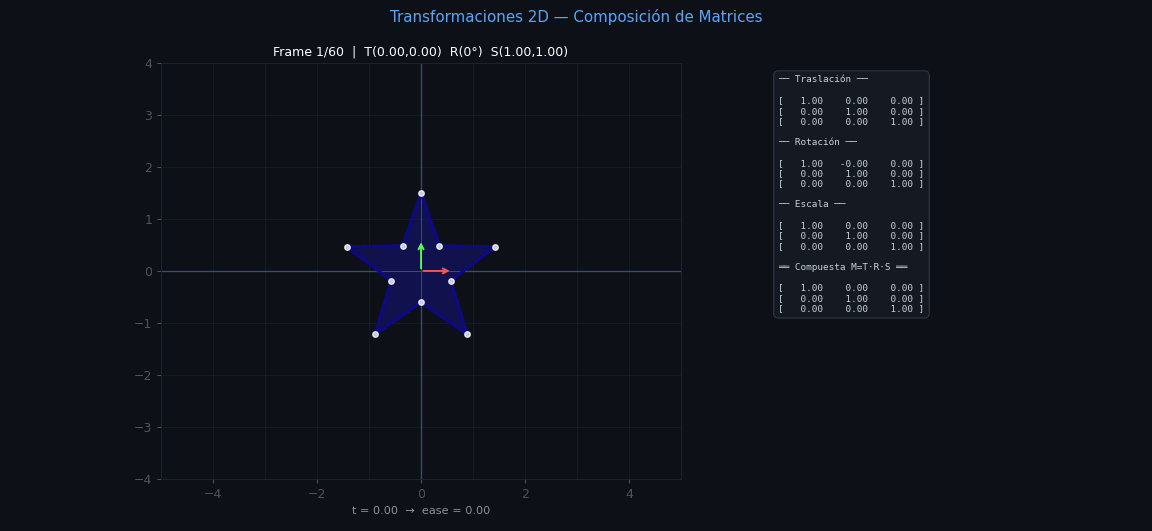

In [5]:
def lerp(a, b, t):
    """Interpolación lineal entre a y b."""
    return a + (b - a) * t

def ease_in_out(t):
    """Suavizado cúbico para animaciones más naturales."""
    return t * t * (3 - 2 * t)

# ── Parámetros de la animación ────────────────────────────────
N_FRAMES = 60          # Número de fotogramas
FPS      = 20          # Velocidad del GIF
GIF_PATH = 'transformacion_compuesta.gif'

# Valores INICIO → FIN de cada transformación
TX_INICIO,  TX_FIN  = 0.0,   2.5
TY_INICIO,  TY_FIN  = 0.0,  -1.0
ANG_INICIO, ANG_FIN = 0.0,   2 * np.pi   # Vuelta completa
SX_INICIO,  SX_FIN  = 1.0,   1.8
SY_INICIO,  SY_FIN  = 1.0,   0.5

frames = []
ts     = np.linspace(0, 1, N_FRAMES)

print(f'Generando {N_FRAMES} frames...')

for i, t_raw in enumerate(ts):
    t = ease_in_out(t_raw)   # Suavizado

    # ── Calcular matrices en función de t ─────────────────────
    tx  = lerp(TX_INICIO,  TX_FIN,  t)
    ty  = lerp(TY_INICIO,  TY_FIN,  t)
    ang = lerp(ANG_INICIO, ANG_FIN, t)
    sx  = lerp(SX_INICIO,  SX_FIN,  t)
    sy  = lerp(SY_INICIO,  SY_FIN,  t)

    T_mat = mat_traslacion(tx, ty)
    R_mat = mat_rotacion(ang)
    S_mat = mat_escala(sx, sy)
    M     = T_mat @ R_mat @ S_mat   # Composición

    # ── Aplicar transformación ─────────────────────────────────
    fig_transform = aplicar_transformacion(FIGURA_BASE, M)

    # ── Renderizar frame ───────────────────────────────────────
    fig_frame = plt.figure(figsize=(14, 6), facecolor='#0d1117')
    gs_frame  = GridSpec(1, 2, figure=fig_frame, wspace=0.05,
                         width_ratios=[2, 1])

    # Panel izquierdo: figura
    ax_fig = fig_frame.add_subplot(gs_frame[0])
    ax_fig.set_facecolor('#0d1117')

    # Grilla
    for v in np.arange(-5, 6, 1):
        ax_fig.axhline(v, color='#1c2333', lw=0.5)
        ax_fig.axvline(v, color='#1c2333', lw=0.5)
    ax_fig.axhline(0, color='#3d4f6e', lw=1)
    ax_fig.axvline(0, color='#3d4f6e', lw=1)

    # Figura original (fantasma)
    cerrado_base = np.vstack([FIGURA_BASE, FIGURA_BASE[0]])
    ax_fig.fill(cerrado_base[:,0], cerrado_base[:,1], color='#ffffff', alpha=0.04)
    ax_fig.plot(cerrado_base[:,0], cerrado_base[:,1], color='#ffffff',
                lw=1, alpha=0.2, ls='--')

    # Figura transformada
    cerrado_t = np.vstack([fig_transform, fig_transform[0]])
    grad_color = plt.cm.plasma(t)
    ax_fig.fill(cerrado_t[:,0], cerrado_t[:,1],
                color=grad_color, alpha=0.45)
    ax_fig.plot(cerrado_t[:,0], cerrado_t[:,1],
                color=grad_color, lw=2.5)
    ax_fig.scatter(fig_transform[:,0], fig_transform[:,1],
                   color='white', s=20, zorder=6, alpha=0.8)

    # Ejes locales de la figura (origen transformado)
    origen_t = aplicar_transformacion(np.array([[0,0]]), M)[0]
    eje_x_t  = aplicar_transformacion(np.array([[0.6,0]]), M)[0]
    eje_y_t  = aplicar_transformacion(np.array([[0,0.6]]), M)[0]
    ax_fig.annotate('', xy=eje_x_t, xytext=origen_t,
                    arrowprops=dict(arrowstyle='->', color='#ff5555', lw=1.5))
    ax_fig.annotate('', xy=eje_y_t, xytext=origen_t,
                    arrowprops=dict(arrowstyle='->', color='#55ff55', lw=1.5))

    ax_fig.set_xlim(-5, 5); ax_fig.set_ylim(-4, 4)
    ax_fig.set_aspect('equal')
    ax_fig.tick_params(colors='#555')
    for sp in ax_fig.spines.values(): sp.set_edgecolor('#1c2333')

    # Barra de progreso
    ax_fig.set_xlabel(f't = {t_raw:.2f}  →  ease = {t:.2f}',
                      color='#8b949e', fontsize=9)
    ax_fig.set_title(
        f'Frame {i+1}/{N_FRAMES}  |  '
        f'T({tx:.2f},{ty:.2f})  R({np.degrees(ang):.0f}°)  S({sx:.2f},{sy:.2f})',
        color='white', fontsize=10
    )

    # Panel derecho: matrices
    ax_mat = fig_frame.add_subplot(gs_frame[1])
    ax_mat.set_facecolor('#0d1117')
    ax_mat.axis('off')

    def fmt_mat_display(M_d, nombre, color_nombre):
        filas = []
        for fila in M_d:
            filas.append('  '.join(f'{v:6.2f}' for v in fila))
        return nombre + '\n' + '\n'.join(f'[ {f} ]' for f in filas)

    texto = (
        f"── Traslación ──\n{fmt_mat_display(T_mat,'','')}\n\n"
        f"── Rotación ──\n{fmt_mat_display(R_mat,'','')}\n\n"
        f"── Escala ──\n{fmt_mat_display(S_mat,'','')}\n\n"
        f"══ Compuesta M=T·R·S ══\n{fmt_mat_display(M,'','')}"
    )
    ax_mat.text(0.05, 0.97, texto,
                transform=ax_mat.transAxes,
                fontsize=7.5, va='top', ha='left',
                color='#c9d1d9',
                fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#161b22',
                          edgecolor='#30363d', alpha=0.95))

    # Barra de progreso visual
    bar_ax = fig_frame.add_axes([0.05, 0.03, 0.9, 0.025])
    bar_ax.set_facecolor('#1c2333')
    bar_ax.barh(0, t_raw, color=grad_color, height=1)
    bar_ax.set_xlim(0, 1); bar_ax.axis('off')

    fig_frame.suptitle('Transformaciones 2D — Composición de Matrices',
                       color='#58a6ff', fontsize=12, y=0.98)

    # Capturar frame
    buf = io.BytesIO()
    fig_frame.savefig(buf, format='png', dpi=90,
                      bbox_inches='tight', facecolor='#0d1117')
    plt.close(fig_frame)
    buf.seek(0)
    frames.append(Image.open(buf).copy())

    if (i + 1) % 10 == 0:
        print(f'  {i+1}/{N_FRAMES} frames completados')

# Exportar GIF
frames[0].save(
    GIF_PATH,
    save_all=True,
    append_images=frames[1:] + frames[::-1],  # Ida y vuelta
    loop=0,
    duration=int(1000 / FPS)
)
print(f'\n✅ GIF guardado: "{GIF_PATH}"  ({N_FRAMES*2} frames, {FPS} fps)')

from IPython.display import Image as IPyImage, display
display(IPyImage(filename=GIF_PATH))